In this notebook, we try to compute the monte carlo distribution of the varcopes in MFX GLM.

In [1]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats
from distribution_plots import *

## Description of the Monte Carlo simulation setup
Study level contrast estimates (denoted $\beta_i$'s) and contrast variance estimates (denoted $\sigma_i$'s) were simulated according to:
$$
\beta_i \sim \mathcal{N}(0, \sigma_i^2+\tau^2)
$$

$$
s^2_i \sim \chi^2_{n-1}*\frac{\sigma_i^2}{n-1}
$$

with 
$$
\sigma_i^2 = \frac{\sigma^2*a_i}{n}
$$

where:
 - $\tau^2=1$ is the between-study variance, 
 - $\sigma_i^2$ is the variance of contrast estimate for study i (i.e. the within-study variance divided by $n$) and 
 - $n=20$ is the number of subjects per studies.
 
6 different simulation schemes were computed:
 - 'diff': $\sigma^2_i \in \{0.25, 0.5, 1, 2, 4\}$
 - '05': $\sigma^2_i=\frac{5}{n}=0.25 \; \forall i$
 - '10': $\sigma^2_i=\frac{10}{n}=0.50 \; \forall i$
 - '20': $\sigma^2_i=\frac{20}{n}=1 \; \forall i$
 - '40': $\sigma^2_i=\frac{40}{n}=2 \; \forall i$
 - '80': $\sigma^2_i=\frac{80}{n}=4 \; \forall i$
 
A total of $38*30*30*30$ random sampling were computed for each simulation setting.

## Load simulation results

In [2]:
# Simulation parameters
nrep = 38; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study

varcope_sigma2 = [0.25, 0.5, 1, 2, 4]
sigma2 = dict(('{num:02d}'.format(num=int(t*nsubjects)), 
               '$\\tau^2 = 1, \sigma^2_i = ' + str(t) + '$')  
              for t in varcope_sigma2) # Possible within-study variances (constant across studies)
sigma2['diff'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$'
sigma2['diff_1.5'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25-4\}$'
sigma2['diff_1.5'] = '$\\tau^2 = 1, \sigma^2_i \in  \{1-5\}'
sigma2['diff_3'] = '$\\tau^2 = 1, \sigma^2_i \in  \{1-32\}'

kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = kstudies - 1 # Degrees of freedom

In [3]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()

hat_taus = {k: [] for k in sigma2.keys()} # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
tstats = {k: [] for k in sigma2.keys()} # tstat1.nii.gz concatenated across (independent) runs & voxels
zstats = {k: [] for k in sigma2.keys()} # zstat1.nii.gz concatenated across (independent) runs & voxels
meta_varcopes = {k: [] for k in sigma2.keys()} # varcope1.nii.gz concatenated across (independent) runs & voxels
meta_copes = {k: [] for k in sigma2.keys()} # cope1.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2.keys():
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    z_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'zstat1.nii.gz')).get_data().flatten()
    zstats[wth] = np.append(zstats[wth], z_data_array)
    t_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'tstat1.nii.gz')).get_data().flatten()
    tstats[wth] = np.append(tstats[wth], t_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], cope_array)

In [4]:
wth_todisp = ['diff', '05', '80'] # Settings to be displayed

## 2D histograms of numerator and denominator of T-statistic

A $T$ is a ratio of a Gaussian distribution and square root multiple of an independent $\chi^2$. However, when doing our GLS, we're using random estimates of $\tau^2$ that influence both the numerator and the denominator. Hence, the whole independence assumption might be off. 

Here we use 2D histograms of the values that go into the numerator and denominator of the final group T stat to check for the independence assumption.

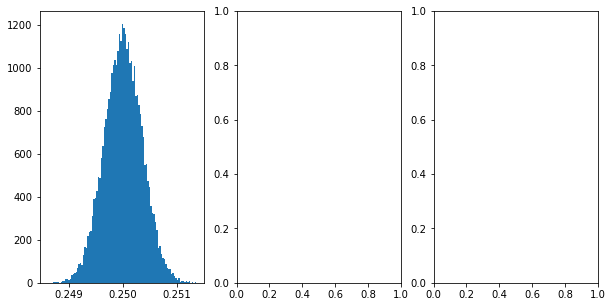

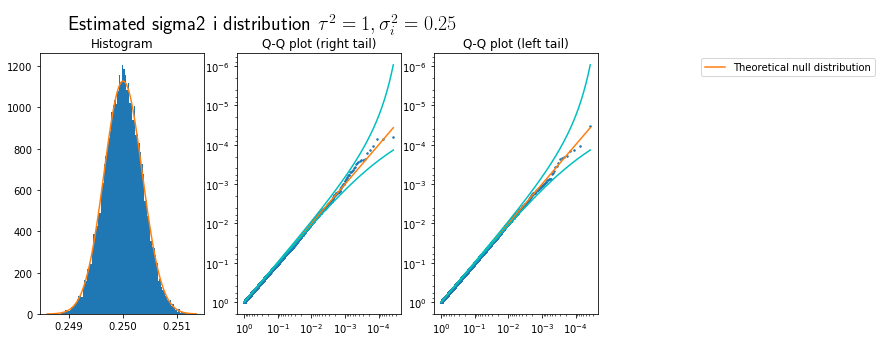

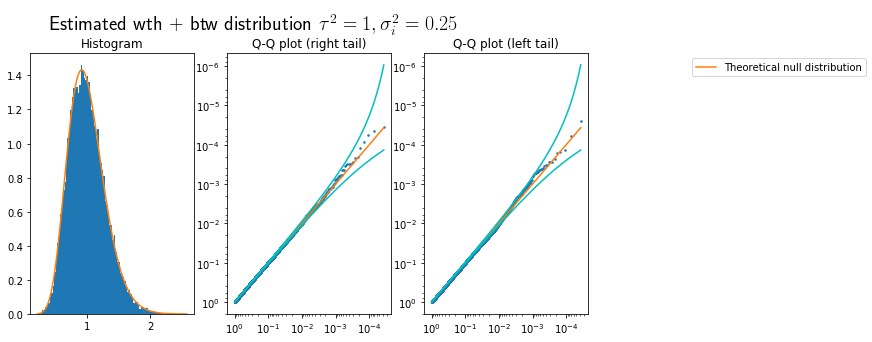

ki
(27000, 25)


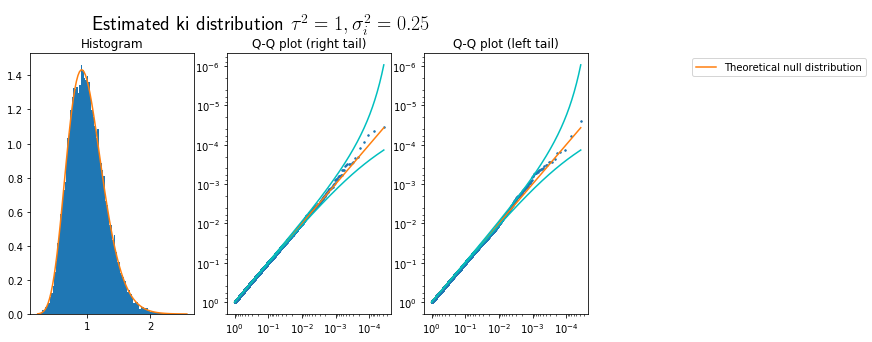

(27000,)


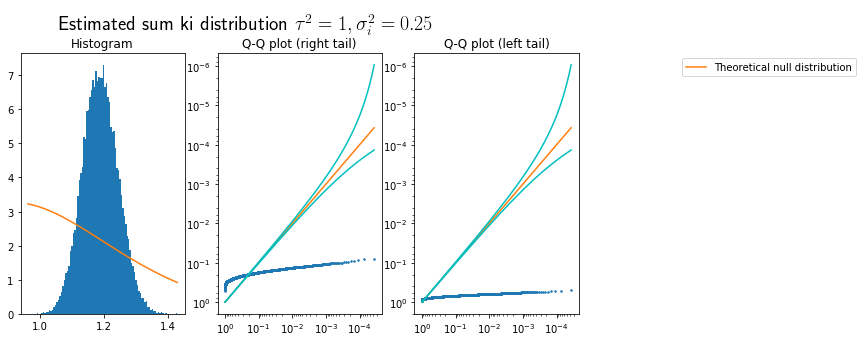

(27000,)
0.0475361289294


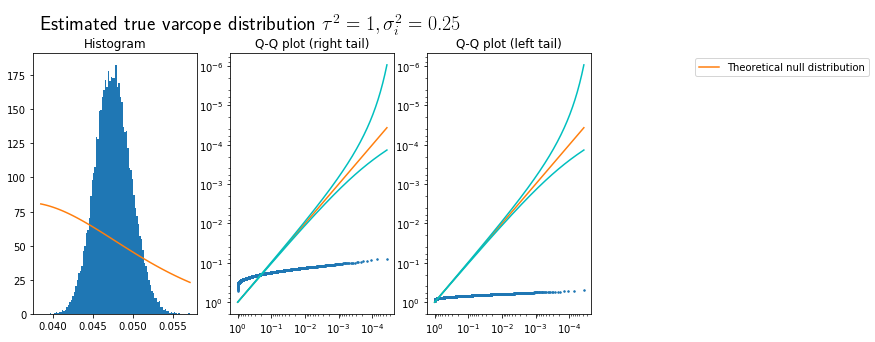

[ 29.14286645  26.87562168  30.67656494 ...,  30.65942927  28.11113876
  30.89033329]
903.592744126
5.2607913508e-05
2.19199639616e-06


In [11]:
npoints = 27000

wth='05'

if wth == 'diff':
    wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
elif wth == '05':
    wth_sigma_a = np.ones(25)

# wth_sigma_a = np.zeros(25)

sigma2_i_s = np.multiply(wth_sigma_a, 0.25)
#     print(sigma2_i_s)

sub_dof = 1000000
sigma2_i_s_simu = np.random.chisquare(sub_dof, (npoints, 1))/sub_dof*sigma2_i_s[0]

for sigma2_i in sigma2_i_s[1:]:
    sigma2_i_s_simu = np.append(sigma2_i_s_simu, np.random.chisquare(sub_dof, (npoints, 1))/sub_dof*sigma2_i, axis=1)
    
    
chi2_distribution_plot(
    sigma2_i_s_simu[:,0], # varcope to display scaled by sigma2/dof
    1,
    'Estimated sigma2 i distribution ' + sigma2[wth], 
    sub_dof, # Parameters of the theoretical Chi2 distribution
    0,
    sigma2_i_s[0]/sub_dof
)

tau2_simu = np.random.chisquare(dof, (npoints, 25))/dof*tau2
# print(np.mean(tau2_simu))
#     print(tau2_simu.shape)
#     print(sigma2_i.shape)

wth_and_btw = np.add(tau2_simu, sigma2_i_s_simu) 

chi2_distribution_plot(
    (wth_and_btw[:,0]-0.25), # varcope to display scaled by sigma2/dof
    1/(dof/1),
    'Estimated wth + btw distribution ' + sigma2[wth], 
    dof # Parameters of the theoretical Chi2 distribution
)

ki = np.divide(1, wth_and_btw)
print("ki")
print(ki.shape)

chi2_distribution_plot(
    (np.divide(1,ki[:,0])-0.25), # varcope to display scaled by sigma2/dof
    tau2/dof,
    'Estimated ki distribution ' + sigma2[wth], 
    dof # Parameters of the theoretical Chi2 distribution
)

# varcope_simu = np.divide(1, np.sum(ki, axis=1))
sum_ki = np.sum(ki, axis=1)
print(sum_ki.shape)

chi2_distribution_plot(
    np.divide(25, sum_ki), # varcope to display scaled by sigma2/dof
    tau2/dof,
    'Estimated sum ki distribution ' + sigma2[wth], 
    dof # Parameters of the theoretical Chi2 distribution
)

varcope_simu = np.divide(1, sum_ki)

print(varcope_simu.shape)
print(np.mean(varcope_simu))

chi2_distribution_plot(
    varcope_simu, # varcope to display scaled by sigma2/dof
    1/(dof*25/1),
    'Estimated true varcope distribution ' + sigma2[wth], 
    dof # Parameters of the theoretical Chi2 distribution
)

print(varcope_simu*dof*25/1)

_mu = np.mean(varcope_simu)
_sigma2 = np.var(varcope_simu)
nu = 2*_mu*_mu/(_sigma2)
print(nu)
c = (_sigma2)/(2*_mu)
print(c)
print(c/dof)

# # simulate_diff_varcope(27000, tau2, dof)
# wth = '05'
# simu_true_varcope = simulate_diff_varcope(wth, 38*30*30*30, tau2, dof)*dof/(cope_th_var[wth])

# chi2_distribution_plot(
#     simu_true_varcope*dof/(1/25), # varcope to display scaled by sigma2/dof
#     'Estimated true varcope distribution ' + sigma2[wth], 
#     dof # Parameters of the theoretical Chi2 distribution
# )


In [6]:
def simulate_diff_varcope(wth, npoints, tau2, dof):     
#     wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
#     sigma2_i = [x * 0.25 for x in wth_sigma_a]

#     tau2_simu = np.random.chisquare(dof, npoints)/dof*tau2

#     sigma2_i_ratios = [1/(tau2_simu + x) for x in sigma2_i]
#     varcope_simu = 1/sum(sigma2_i_ratios)

    if wth == 'diff':
        wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
    elif wth == '05':
        wth_sigma_a = np.ones(25)
        
    wth_sigma_a = np.zeros(25)

    sigma2_i_s = np.multiply(wth_sigma_a, 0.25)
#     print(sigma2_i_s)


    sigma2_i_s_simu = np.random.chisquare(19, (npoints, 1))/19*sigma2_i_s[0]

    for sigma2_i in sigma2_i_s[1:]:
        sigma2_i_s_simu = np.append(sigma2_i_s_simu, np.random.chisquare(19, (npoints, 1))/19*sigma2_i, axis=1)

    tau2_simu = np.random.chisquare(dof, (npoints, 25))/dof*tau2
    # print(np.mean(tau2_simu))
    #     print(tau2_simu.shape)
    #     print(sigma2_i.shape)

    varcope_simu = np.divide(1, np.sum(np.divide(1, np.add(tau2_simu, sigma2_i_s_simu)), axis=1))
    return(varcope_simu)

# simulate_diff_varcope(27000, tau2, dof)
wth = '05'
simu_true_varcope = simulate_diff_varcope(wth, 38*30*30*30, tau2, dof)*dof/(cope_th_var[wth])

chi2_distribution_plot(
    simu_true_varcope*dof/1, # varcope to display scaled by sigma2/dof
    'Estimated true varcope distribution ' + sigma2[wth], 
    dof # Parameters of the theoretical Chi2 distribution
)

print(dof)

_mu = np.mean(simu_true_varcope)
_sigma2 = np.var(simu_true_varcope)
nu = 2*_mu*_mu/(_sigma2)
c = (_sigma2)/(2*_mu)
print('Estimated dof of meta-analytic varcope1 (over ' + str(nreal) + ' realisations) for \'' + wth + '\': ' + 
      ' nu=' + "{0:.1f}".format(nu) + '/ True nu=' + str(dof) )

# np.mean(simulate_diff_varcope(270000, tau2, dof))

NameError: name 'cope_th_var' is not defined